# Financial Markets Project
Deep Learning and Applied AI at Sapienza Univerisity 2021 

Author: Klaudia Palak and Hossein

In [ ]:
#Installation 
!pip install pandas-ta
!pip install yfinance
#Import
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
#Clear
from IPython.display import clear_output 
clear_output()

## Dataset preparation

### Load data

In [ ]:
dataset = yf.download('AAPL','2012-01-01','2021-06-01')
print (dataset.head())
print (dataset.count())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-01-03  14.621429  14.732143  14.607143  14.686786  12.629209  302220800
2012-01-04  14.642857  14.810000  14.617143  14.765714  12.697079  260022000
2012-01-05  14.819643  14.948214  14.738214  14.929643  12.838044  271269600
2012-01-06  14.991786  15.098214  14.972143  15.085714  12.972249  318292800
2012-01-09  15.196429  15.276786  15.048214  15.061786  12.951672  394024400
Open         2367
High         2367
Low          2367
Close        2367
Adj Close    2367
Volume       2367
dtype: int64


In [ ]:
# number of GPUs from cuda
GPU_numbers = torch.cuda.device_count()
print("Available GPUs:", GPU_numbers)
print("GPU {}: {}".format(1, torch.cuda.get_device_name(0)))

Available GPUs: 1
GPU 1: Tesla T4


## Hyperparameters

In [ ]:
#configuration
batch_size = 64
optimizer_betas = (0.9, 0.999)
learning_rate = 5e-4
num_epochs = 2000
device = torch.device("cuda:0" if (torch.cuda.is_available() and GPU_numbers > 1) else "cpu")

### Create dataset and dataloader

In [ ]:
class Timedata(Dataset):
    def __init__(self, data_frame, length_seq=2):
        self.data = torch.tensor(data_frame.values)
        self.length_seq = length_seq

    def __len__(self):
        return self.data.shape[0] - self.length_seq + 1

    def __getitem__(self, index):
        return self.data[index: index + self.length_seq].float()

In [ ]:
# create pytorch dataset 
training_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
data_dimension = len(training_columns)
# sequence length
length_seq = 5

train_data, rest_data = train_test_split(dataset[training_columns], test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data[train_data.columns] = scaler.transform(train_data)
rest_data[rest_data.columns] = scaler.transform(rest_data)

validation_data, test_data = train_test_split(rest_data, test_size=0.5, shuffle=False)

train_dataset = Timedata(train_data, length_seq)
test_dataset = Timedata(test_data, length_seq)
validation_dataset = Timedata(validation_data, length_seq)

# create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
real_data_sample = next(iter(train_dataloader))
print("Real data sample shape:", real_data_sample.shape)

Real data sample shape: torch.Size([64, 5, 6])


## Model

In [ ]:
class Main_Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Main_Generator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=data_dimension, hidden_size=hidden_size, num_layers=1, dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_size, data_dimension)
        self.drop = nn.Dropout(0.2)

    def forward(self, input_sequences):
        input_sequences = self.drop(input_sequences)
        lstm_output, hidden_cell = self.lstm(input_sequences)
        res = self.linear(hidden_cell[0][-1])
        res = res.view(res.shape[0], 1, -1)
        return res

In [ ]:
class Main_Discriminator(nn.Module):
    def __init__(self):
        super(Main_Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(length_seq*data_dimension, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_sequences):
        input_sequences_flattened = input_sequences.view(input_sequences.shape[0], -1)
        res = self.model(input_sequences_flattened)
        return res

In [ ]:
def model_RMSE(model, dataloader, plot_graph=False, plot_title="Validation Predictions"):
    RMSE = 0
    squared_error_list = []
    real_data_list = []
    predicted_data_list = []
    for i, sequence_batch in enumerate(dataloader):
        with torch.no_grad():
            seq_real = sequence_batch
            seq_input_gen = sequence_batch[:,:-1].to(device)
            real_values = sequence_batch[:,-1:]
            predicted_values = gen(seq_input_gen).cpu()
            squared_error_list.append((predicted_values - real_values) ** 2)
            real_data_list.append(real_values)
            predicted_data_list.append(predicted_values)
    squared_errors = torch.cat(squared_error_list, 0)
    real_data = torch.cat(real_data_list, 0)
    predicted_data = torch.cat(predicted_data_list, 0)
    if plot_graph:
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(plot_title)
        plt.plot(real_data[:,:,0].view(-1),label="Real")
        plt.plot(predicted_data[:,:,0].view(-1),label="Predicted")
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()
    RMSE = np.sqrt(squared_errors.mean())
    return RMSE

In [ ]:
gen = Main_Generator(hidden_size=data_dimension*2).to(device)
dis = Main_Discriminator().to(device)
print("Generator and discriminator are initialized")

Generator and discriminator are initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
criterion_error = nn.BCELoss()
optimizer_generator = optim.Adam(gen.parameters(), lr=learning_rate, betas=optimizer_betas)
dis_optimizer = optim.Adam(dis.parameters(), lr=learning_rate, betas=optimizer_betas)

Label_real = 1.
Label_fake = 0.

## Train Model

In [ ]:
if not os.path.exists('./models/'):
    os.makedirs('./models/')

Training is started


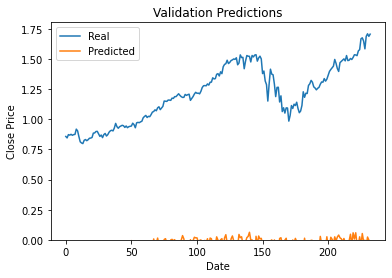


[1/2000]	Discriminator Loss: 1.3670	Generator Loss: 0.6967   	RMSE:0.9939
Open | Real:0.1381 / Generated:-0.1552
High | Real:0.1403 / Generated:0.0917
Low | Real:0.1374 / Generated:-0.1251
Close | Real:0.1459 / Generated:0.4565
Adj Close | Real:0.1213 / Generated:0.2203
Volume | Real:0.3693 / Generated:-0.2543


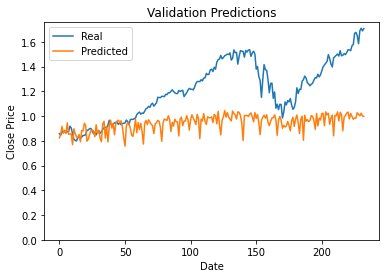


[5/2000]	Discriminator Loss: 1.3725	Generator Loss: 0.6885   	RMSE:0.4726
Open | Real:0.0379 / Generated:0.3305
High | Real:0.0289 / Generated:0.7358
Low | Real:0.0321 / Generated:0.3741
Close | Real:0.0285 / Generated:0.7281
Adj Close | Real:0.0248 / Generated:0.3833
Volume | Real:0.2840 / Generated:0.2618


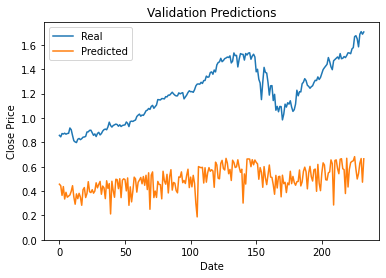


[10/2000]	Discriminator Loss: 1.3758	Generator Loss: 0.7059   	RMSE:1.1322
Open | Real:0.3232 / Generated:0.1864
High | Real:0.3256 / Generated:-0.0760
Low | Real:0.3261 / Generated:0.2557
Close | Real:0.3302 / Generated:-0.4116
Adj Close | Real:0.3107 / Generated:0.2048
Volume | Real:0.0612 / Generated:0.0245


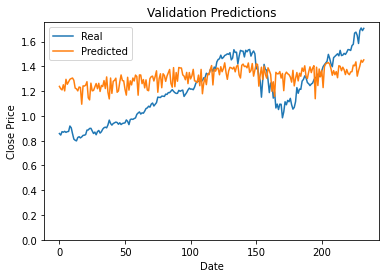


[15/2000]	Discriminator Loss: 1.3710	Generator Loss: 0.7320   	RMSE:0.3532
Open | Real:0.1014 / Generated:0.6457
High | Real:0.0972 / Generated:0.7170
Low | Real:0.1023 / Generated:0.5291
Close | Real:0.1044 / Generated:0.7348
Adj Close | Real:0.0888 / Generated:0.6362
Volume | Real:0.3771 / Generated:0.2684


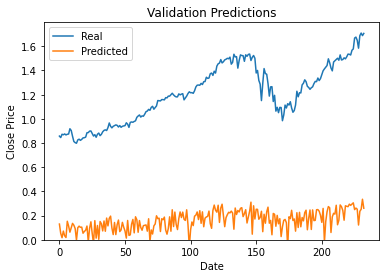


[20/2000]	Discriminator Loss: 1.3584	Generator Loss: 0.7194   	RMSE:0.9237
Open | Real:0.4864 / Generated:0.0145
High | Real:0.4759 / Generated:0.1395
Low | Real:0.4878 / Generated:-0.0877
Close | Real:0.4816 / Generated:0.4880
Adj Close | Real:0.4800 / Generated:0.1426
Volume | Real:0.0216 / Generated:-0.2033


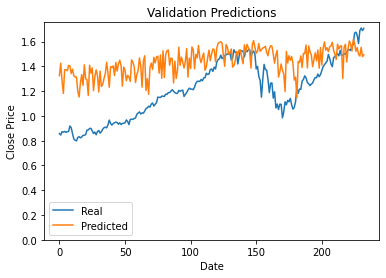


[25/2000]	Discriminator Loss: 1.3890	Generator Loss: 0.6661   	RMSE:0.6176
Open | Real:0.6694 / Generated:1.2531
High | Real:0.6759 / Generated:1.0564
Low | Real:0.6720 / Generated:1.2289
Close | Real:0.6831 / Generated:0.5019
Adj Close | Real:0.6858 / Generated:0.2728
Volume | Real:0.0742 / Generated:0.8173


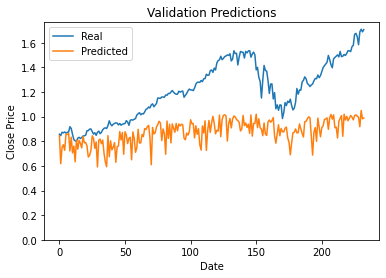


[30/2000]	Discriminator Loss: 1.4140	Generator Loss: 0.6911   	RMSE:0.4251
Open | Real:0.5755 / Generated:0.5484
High | Real:0.5686 / Generated:0.5454
Low | Real:0.5763 / Generated:0.6341
Close | Real:0.5685 / Generated:0.5538
Adj Close | Real:0.5690 / Generated:0.4270
Volume | Real:0.0130 / Generated:0.0351


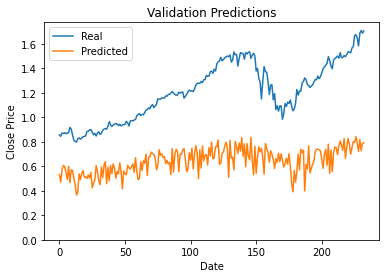


[35/2000]	Discriminator Loss: 1.3666	Generator Loss: 0.7614   	RMSE:0.6301
Open | Real:0.2192 / Generated:0.0736
High | Real:0.2096 / Generated:0.1597
Low | Real:0.2179 / Generated:0.1119
Close | Real:0.2138 / Generated:0.2597
Adj Close | Real:0.2007 / Generated:0.1933
Volume | Real:0.0468 / Generated:0.0262


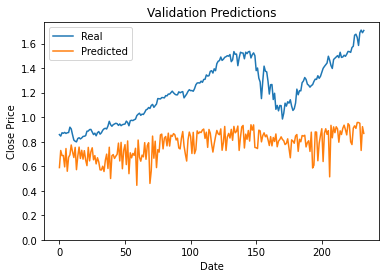


[40/2000]	Discriminator Loss: 1.3414	Generator Loss: 0.6938   	RMSE:0.4132
Open | Real:0.2467 / Generated:0.2595
High | Real:0.2440 / Generated:0.2903
Low | Real:0.2370 / Generated:0.1991
Close | Real:0.2307 / Generated:0.4138
Adj Close | Real:0.2289 / Generated:0.4770
Volume | Real:0.1910 / Generated:0.0964


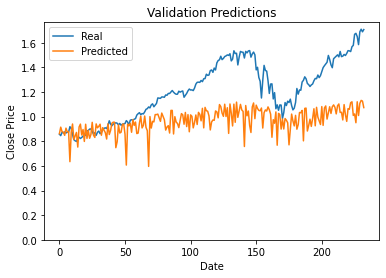


[45/2000]	Discriminator Loss: 1.3505	Generator Loss: 0.6596   	RMSE:0.3615
Open | Real:0.1931 / Generated:0.1271
High | Real:0.1877 / Generated:-0.0254
Low | Real:0.1924 / Generated:0.1987
Close | Real:0.1882 / Generated:0.0101
Adj Close | Real:0.1576 / Generated:0.0308
Volume | Real:0.3895 / Generated:0.2086


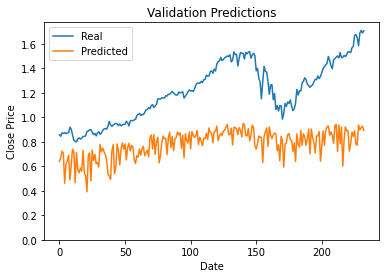


[50/2000]	Discriminator Loss: 1.3765	Generator Loss: 0.7017   	RMSE:0.3229
Open | Real:0.1118 / Generated:-0.0108
High | Real:0.1056 / Generated:0.1232
Low | Real:0.0986 / Generated:0.1994
Close | Real:0.1111 / Generated:0.0477
Adj Close | Real:0.0947 / Generated:0.0729
Volume | Real:0.8362 / Generated:0.2913


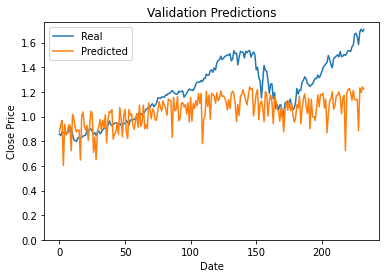


[55/2000]	Discriminator Loss: 1.3507	Generator Loss: 0.7104   	RMSE:0.3131
Open | Real:0.2768 / Generated:0.2764
High | Real:0.2727 / Generated:0.2904
Low | Real:0.2794 / Generated:0.1658
Close | Real:0.2768 / Generated:0.2341
Adj Close | Real:0.2744 / Generated:0.3302
Volume | Real:0.0786 / Generated:0.1688


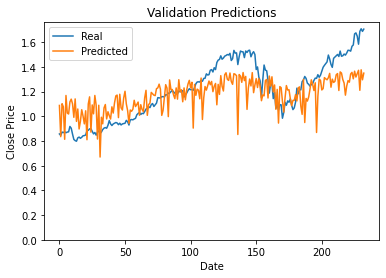


[60/2000]	Discriminator Loss: 1.3747	Generator Loss: 0.7143   	RMSE:0.3308
Open | Real:0.2108 / Generated:0.2938
High | Real:0.2115 / Generated:0.1301
Low | Real:0.2096 / Generated:0.2635
Close | Real:0.2161 / Generated:0.2234
Adj Close | Real:0.2211 / Generated:0.1261
Volume | Real:0.1366 / Generated:0.1454


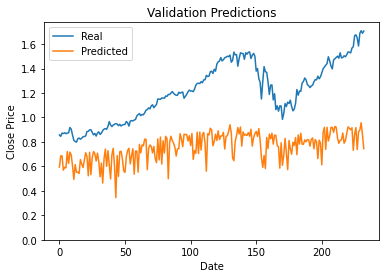


[65/2000]	Discriminator Loss: 1.3242	Generator Loss: 0.7420   	RMSE:0.2959
Open | Real:0.3233 / Generated:0.1630
High | Real:0.3130 / Generated:0.4718
Low | Real:0.3131 / Generated:0.3354
Close | Real:0.3067 / Generated:0.3853
Adj Close | Real:0.3021 / Generated:0.4773
Volume | Real:0.0974 / Generated:0.2724


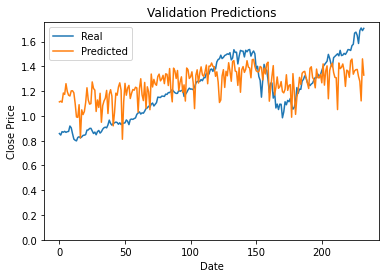


[70/2000]	Discriminator Loss: 1.4101	Generator Loss: 0.7421   	RMSE:0.3808
Open | Real:0.3233 / Generated:0.4863
High | Real:0.3130 / Generated:0.3211
Low | Real:0.3131 / Generated:0.3068
Close | Real:0.3067 / Generated:0.2884
Adj Close | Real:0.3021 / Generated:0.2808
Volume | Real:0.0974 / Generated:-0.0079


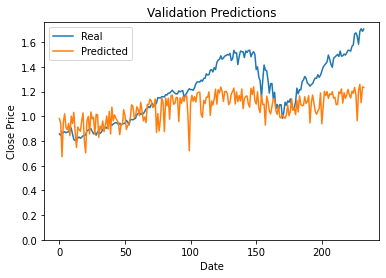


[75/2000]	Discriminator Loss: 1.3433	Generator Loss: 0.7208   	RMSE:0.3239
Open | Real:0.3914 / Generated:0.5282
High | Real:0.3930 / Generated:0.4270
Low | Real:0.3947 / Generated:0.6501
Close | Real:0.4004 / Generated:0.5010
Adj Close | Real:0.3769 / Generated:0.4257
Volume | Real:0.0979 / Generated:0.2527


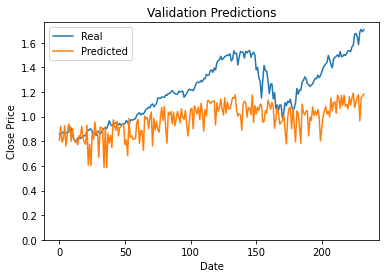


[80/2000]	Discriminator Loss: 1.3860	Generator Loss: 0.6868   	RMSE:0.3527
Open | Real:0.5077 / Generated:0.5243
High | Real:0.4982 / Generated:0.5519
Low | Real:0.5079 / Generated:0.4563
Close | Real:0.5005 / Generated:0.4863
Adj Close | Real:0.5011 / Generated:0.5524
Volume | Real:0.0319 / Generated:0.0189


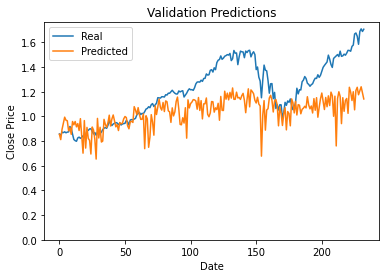


[85/2000]	Discriminator Loss: 1.3306	Generator Loss: 0.7042   	RMSE:0.3467
Open | Real:0.0457 / Generated:0.0723
High | Real:0.0487 / Generated:0.0767
Low | Real:0.0467 / Generated:0.0625
Close | Real:0.0545 / Generated:0.0044
Adj Close | Real:0.0457 / Generated:0.0702
Volume | Real:0.3614 / Generated:0.3263


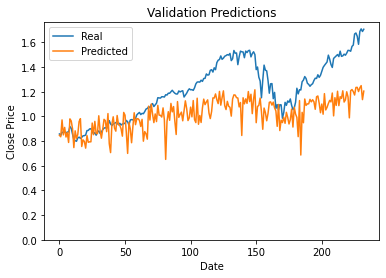


[90/2000]	Discriminator Loss: 1.3142	Generator Loss: 0.8095   	RMSE:0.3166
Open | Real:0.3485 / Generated:0.3412
High | Real:0.3566 / Generated:0.2932
Low | Real:0.3520 / Generated:0.4503
Close | Real:0.3627 / Generated:0.3977
Adj Close | Real:0.3480 / Generated:0.3252
Volume | Real:0.1194 / Generated:0.1318


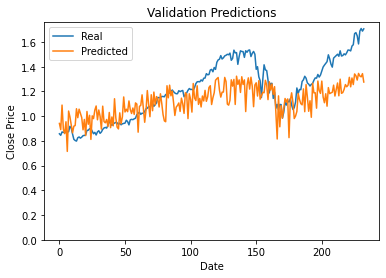


[95/2000]	Discriminator Loss: 1.3440	Generator Loss: 0.8001   	RMSE:0.3232
Open | Real:0.6353 / Generated:0.9175
High | Real:0.6227 / Generated:0.8960
Low | Real:0.6241 / Generated:0.5467
Close | Real:0.6209 / Generated:0.7010
Adj Close | Real:0.6259 / Generated:0.8037
Volume | Real:0.0689 / Generated:0.0285


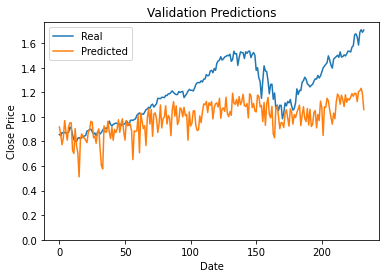


[100/2000]	Discriminator Loss: 1.3382	Generator Loss: 0.7026   	RMSE:0.3056
Open | Real:0.1385 / Generated:0.0688
High | Real:0.1334 / Generated:0.0764
Low | Real:0.1355 / Generated:0.2152
Close | Real:0.1302 / Generated:0.0917
Adj Close | Real:0.1210 / Generated:0.0567
Volume | Real:0.2924 / Generated:0.2545


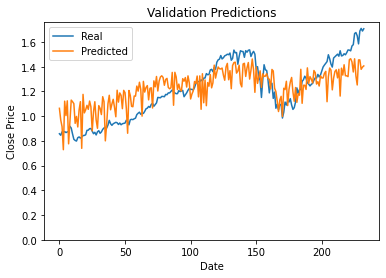


[105/2000]	Discriminator Loss: 1.2931	Generator Loss: 0.7901   	RMSE:0.2995
Open | Real:0.3588 / Generated:0.4562
High | Real:0.3580 / Generated:0.3855
Low | Real:0.3617 / Generated:0.3283
Close | Real:0.3643 / Generated:0.4347
Adj Close | Real:0.3661 / Generated:0.4489
Volume | Real:0.0632 / Generated:0.1332


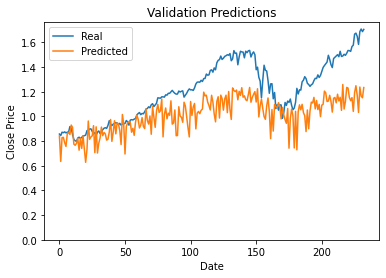


[110/2000]	Discriminator Loss: 1.3063	Generator Loss: 0.7689   	RMSE:0.3301
Open | Real:0.6137 / Generated:0.4515
High | Real:0.6262 / Generated:0.5240
Low | Real:0.6172 / Generated:0.5803
Close | Real:0.6330 / Generated:0.4287
Adj Close | Real:0.6376 / Generated:0.4542
Volume | Real:0.0802 / Generated:0.1052


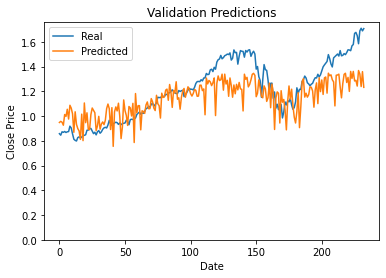


[115/2000]	Discriminator Loss: 1.2326	Generator Loss: 0.8420   	RMSE:0.2749
Open | Real:0.5821 / Generated:0.5869
High | Real:0.5714 / Generated:0.5226
Low | Real:0.5777 / Generated:0.4595
Close | Real:0.5731 / Generated:0.5176
Adj Close | Real:0.5893 / Generated:0.5400
Volume | Real:0.0613 / Generated:0.0858


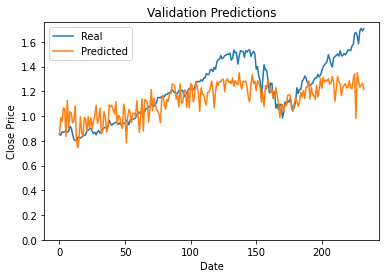


[120/2000]	Discriminator Loss: 1.3033	Generator Loss: 0.7984   	RMSE:0.2916
Open | Real:0.3453 / Generated:0.3972
High | Real:0.3368 / Generated:0.3190
Low | Real:0.3382 / Generated:0.3748
Close | Real:0.3366 / Generated:0.3333
Adj Close | Real:0.3240 / Generated:0.3354
Volume | Real:0.1138 / Generated:0.1403


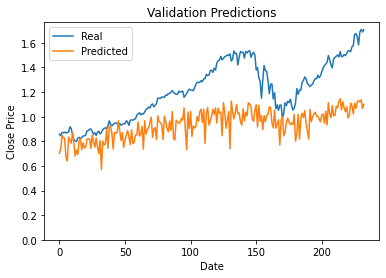


[125/2000]	Discriminator Loss: 1.2763	Generator Loss: 0.8370   	RMSE:0.2824
Open | Real:0.5466 / Generated:0.5994
High | Real:0.5457 / Generated:0.6600
Low | Real:0.5500 / Generated:0.6537
Close | Real:0.5488 / Generated:0.6202
Adj Close | Real:0.5470 / Generated:0.6205
Volume | Real:0.0608 / Generated:0.1306


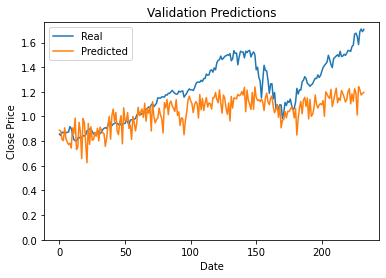


[130/2000]	Discriminator Loss: 1.1508	Generator Loss: 1.1823   	RMSE:0.2747
Open | Real:0.3393 / Generated:0.4200
High | Real:0.3286 / Generated:0.3641
Low | Real:0.3336 / Generated:0.4179
Close | Real:0.3285 / Generated:0.3939
Adj Close | Real:0.3191 / Generated:0.3996
Volume | Real:0.0445 / Generated:0.1414


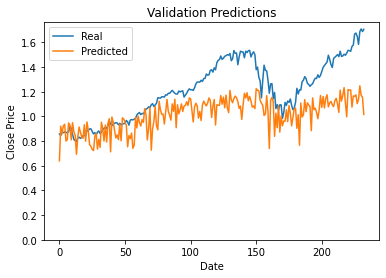


[135/2000]	Discriminator Loss: 1.1997	Generator Loss: 0.8782   	RMSE:0.2640
Open | Real:0.1592 / Generated:0.1637
High | Real:0.1542 / Generated:0.1755
Low | Real:0.1618 / Generated:0.1672
Close | Real:0.1596 / Generated:0.1761
Adj Close | Real:0.1330 / Generated:0.1776
Volume | Real:0.2163 / Generated:0.1851


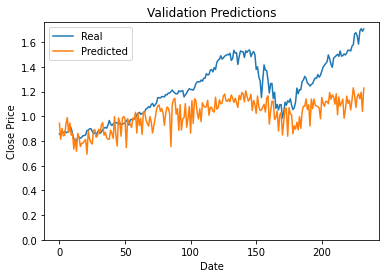


[140/2000]	Discriminator Loss: 1.1718	Generator Loss: 1.0365   	RMSE:0.2514
Open | Real:0.3112 / Generated:0.3590
High | Real:0.3003 / Generated:0.3410
Low | Real:0.2955 / Generated:0.3533
Close | Real:0.2895 / Generated:0.3509
Adj Close | Real:0.2738 / Generated:0.3753
Volume | Real:0.1332 / Generated:0.0949


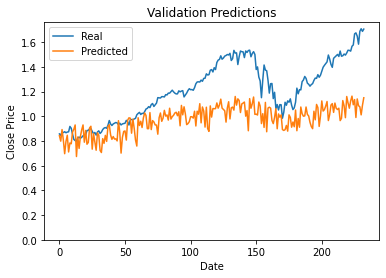


[145/2000]	Discriminator Loss: 1.3128	Generator Loss: 0.9208   	RMSE:0.2534
Open | Real:0.1991 / Generated:0.2128
High | Real:0.1908 / Generated:0.2332
Low | Real:0.1952 / Generated:0.1789
Close | Real:0.1979 / Generated:0.2094
Adj Close | Real:0.1679 / Generated:0.1987
Volume | Real:0.2650 / Generated:0.3056


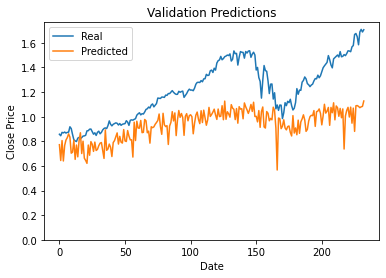


[150/2000]	Discriminator Loss: 1.1605	Generator Loss: 1.1238   	RMSE:0.2779
Open | Real:0.1648 / Generated:0.1509
High | Real:0.1548 / Generated:0.1244
Low | Real:0.1594 / Generated:0.1388
Close | Real:0.1559 / Generated:0.1426
Adj Close | Real:0.1316 / Generated:0.1389
Volume | Real:0.2256 / Generated:0.2308


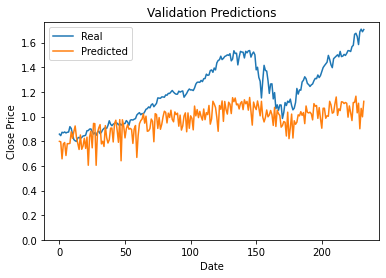


[155/2000]	Discriminator Loss: 1.3122	Generator Loss: 0.8434   	RMSE:0.2570
Open | Real:0.3632 / Generated:0.3553
High | Real:0.3545 / Generated:0.3545
Low | Real:0.3650 / Generated:0.3409
Close | Real:0.3588 / Generated:0.3518
Adj Close | Real:0.3609 / Generated:0.3711
Volume | Real:0.0404 / Generated:0.0987


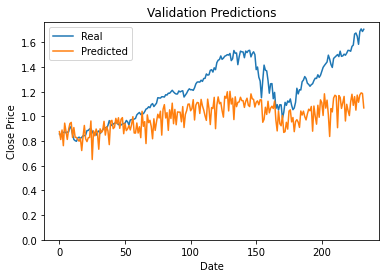


[160/2000]	Discriminator Loss: 1.3045	Generator Loss: 0.9003   	RMSE:0.2328
Open | Real:0.1844 / Generated:0.1859
High | Real:0.1742 / Generated:0.1992
Low | Real:0.1774 / Generated:0.1336
Close | Real:0.1760 / Generated:0.1374
Adj Close | Real:0.1471 / Generated:0.0910
Volume | Real:0.3359 / Generated:0.5954


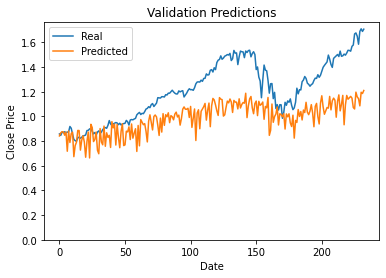


[165/2000]	Discriminator Loss: 1.2862	Generator Loss: 0.8961   	RMSE:0.2332
Open | Real:0.8278 / Generated:0.7025
High | Real:0.8578 / Generated:0.7205
Low | Real:0.8316 / Generated:0.7808
Close | Real:0.8600 / Generated:0.7157
Adj Close | Real:0.8603 / Generated:0.6896
Volume | Real:0.1398 / Generated:-0.0418


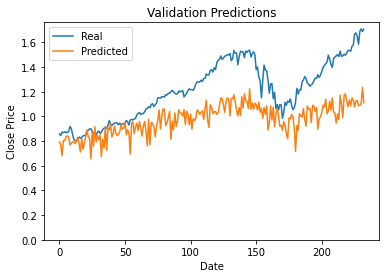


[170/2000]	Discriminator Loss: 1.1762	Generator Loss: 0.9202   	RMSE:0.2322
Open | Real:0.3273 / Generated:0.3347
High | Real:0.3177 / Generated:0.2980
Low | Real:0.3158 / Generated:0.3005
Close | Real:0.3097 / Generated:0.3102
Adj Close | Real:0.2921 / Generated:0.3293
Volume | Real:0.0823 / Generated:0.0586


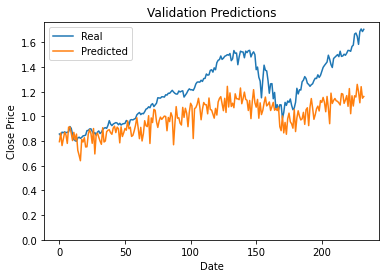


[175/2000]	Discriminator Loss: 1.1204	Generator Loss: 1.1831   	RMSE:0.2194
Open | Real:0.1156 / Generated:0.1169
High | Real:0.1078 / Generated:0.1081
Low | Real:0.1163 / Generated:0.1234
Close | Real:0.1120 / Generated:0.1192
Adj Close | Real:0.1070 / Generated:0.1210
Volume | Real:0.1116 / Generated:0.1836


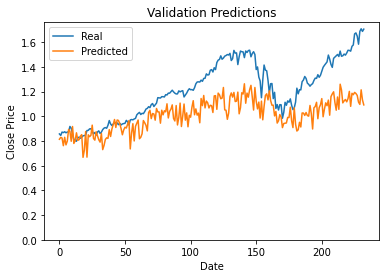


[180/2000]	Discriminator Loss: 1.2083	Generator Loss: 0.9319   	RMSE:0.2068
Open | Real:0.3011 / Generated:0.3134
High | Real:0.3017 / Generated:0.2931
Low | Real:0.3032 / Generated:0.2852
Close | Real:0.3041 / Generated:0.2983
Adj Close | Real:0.2846 / Generated:0.3024
Volume | Real:0.1121 / Generated:0.0648


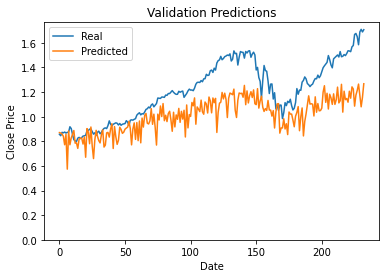


[185/2000]	Discriminator Loss: 1.0854	Generator Loss: 0.9302   	RMSE:0.2162
Open | Real:0.1709 / Generated:0.1516
High | Real:0.1660 / Generated:0.1603
Low | Real:0.1720 / Generated:0.1546
Close | Real:0.1692 / Generated:0.1707
Adj Close | Real:0.1413 / Generated:0.1498
Volume | Real:0.3960 / Generated:0.3554


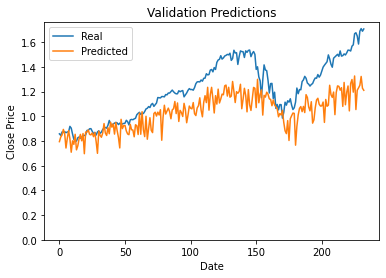


[190/2000]	Discriminator Loss: 1.0900	Generator Loss: 1.1193   	RMSE:0.1941
Open | Real:0.5409 / Generated:0.4913
High | Real:0.5460 / Generated:0.5397
Low | Real:0.5438 / Generated:0.5103
Close | Real:0.5518 / Generated:0.5071
Adj Close | Real:0.5686 / Generated:0.5210
Volume | Real:0.0475 / Generated:0.1069


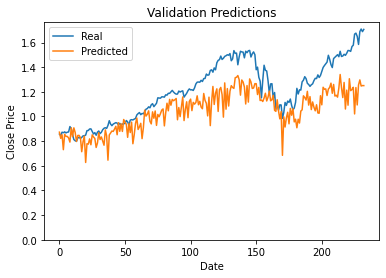


[195/2000]	Discriminator Loss: 1.1752	Generator Loss: 1.1259   	RMSE:0.1759
Open | Real:0.2953 / Generated:0.2756
High | Real:0.2898 / Generated:0.2738
Low | Real:0.2957 / Generated:0.2759
Close | Real:0.2948 / Generated:0.2735
Adj Close | Real:0.2785 / Generated:0.2608
Volume | Real:0.0787 / Generated:0.1817


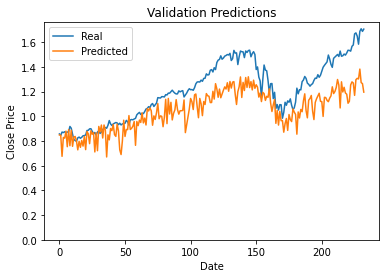


[200/2000]	Discriminator Loss: 1.2268	Generator Loss: 0.9445   	RMSE:0.1555
Open | Real:0.3739 / Generated:0.3836
High | Real:0.3636 / Generated:0.3875
Low | Real:0.3687 / Generated:0.3801
Close | Real:0.3614 / Generated:0.3772
Adj Close | Real:0.3468 / Generated:0.3929
Volume | Real:0.1041 / Generated:0.0114


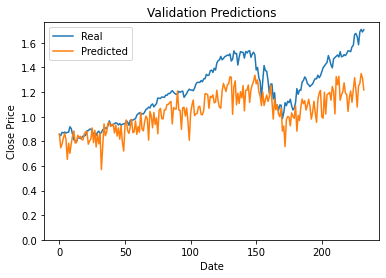


[205/2000]	Discriminator Loss: 1.2326	Generator Loss: 0.9933   	RMSE:0.1761
Open | Real:0.0499 / Generated:0.0589
High | Real:0.0421 / Generated:0.0577
Low | Real:0.0503 / Generated:0.0767
Close | Real:0.0489 / Generated:0.0468
Adj Close | Real:0.0426 / Generated:0.0472
Volume | Real:0.1953 / Generated:0.2910


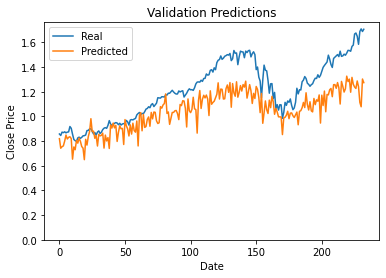


[210/2000]	Discriminator Loss: 1.2357	Generator Loss: 0.9015   	RMSE:0.1759
Open | Real:0.3450 / Generated:0.3355
High | Real:0.3370 / Generated:0.3256
Low | Real:0.3399 / Generated:0.3593
Close | Real:0.3431 / Generated:0.3231
Adj Close | Real:0.3300 / Generated:0.3231
Volume | Real:0.0876 / Generated:0.1031


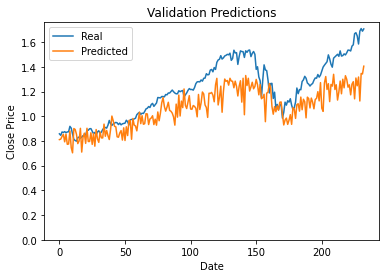


[215/2000]	Discriminator Loss: 1.3174	Generator Loss: 1.1208   	RMSE:0.1635
Open | Real:0.3096 / Generated:0.2586
High | Real:0.3031 / Generated:0.2417
Low | Real:0.3127 / Generated:0.2502
Close | Real:0.3079 / Generated:0.2558
Adj Close | Real:0.3129 / Generated:0.2561
Volume | Real:0.0467 / Generated:0.0778


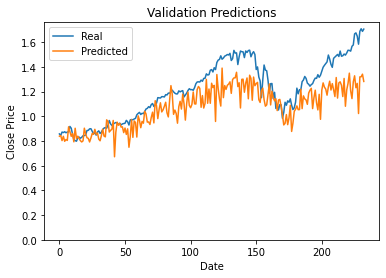


[220/2000]	Discriminator Loss: 1.2685	Generator Loss: 1.1492   	RMSE:0.1619
Open | Real:0.0430 / Generated:0.0377
High | Real:0.0339 / Generated:0.0190
Low | Real:0.0415 / Generated:0.0452
Close | Real:0.0389 / Generated:0.0176
Adj Close | Real:0.0359 / Generated:0.0194
Volume | Real:0.1260 / Generated:0.2632


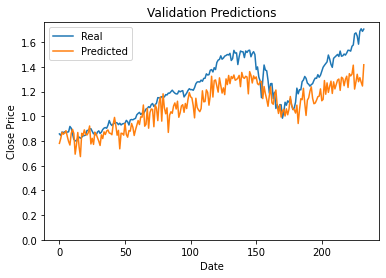


[225/2000]	Discriminator Loss: 1.2098	Generator Loss: 0.9784   	RMSE:0.1537
Open | Real:0.0255 / Generated:0.0269
High | Real:0.0214 / Generated:0.0307
Low | Real:0.0246 / Generated:0.0379
Close | Real:0.0213 / Generated:0.0478
Adj Close | Real:0.0205 / Generated:0.0305
Volume | Real:0.2135 / Generated:0.1288


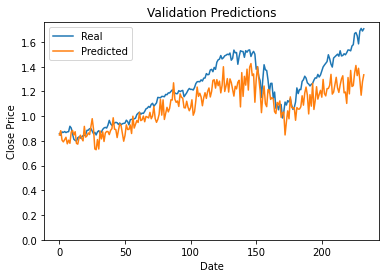


[230/2000]	Discriminator Loss: 1.2117	Generator Loss: 0.7684   	RMSE:0.1653
Open | Real:0.2508 / Generated:0.2405
High | Real:0.2472 / Generated:0.2330
Low | Real:0.2535 / Generated:0.2158
Close | Real:0.2538 / Generated:0.2433
Adj Close | Real:0.2392 / Generated:0.2328
Volume | Real:0.1589 / Generated:0.1231


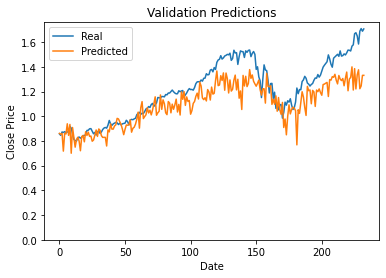


[235/2000]	Discriminator Loss: 1.2885	Generator Loss: 1.0144   	RMSE:0.1573
Open | Real:0.1282 / Generated:0.1387
High | Real:0.1198 / Generated:0.1282
Low | Real:0.1185 / Generated:0.1316
Close | Real:0.1131 / Generated:0.1318
Adj Close | Real:0.0931 / Generated:0.1256
Volume | Real:0.4599 / Generated:0.2927


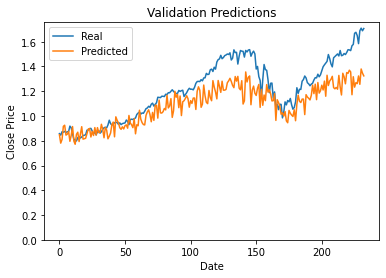


[240/2000]	Discriminator Loss: 1.2658	Generator Loss: 0.9232   	RMSE:0.1550
Open | Real:0.0409 / Generated:0.0478
High | Real:0.0372 / Generated:0.0321
Low | Real:0.0401 / Generated:0.0505
Close | Real:0.0398 / Generated:0.0364
Adj Close | Real:0.0368 / Generated:0.0356
Volume | Real:0.2811 / Generated:0.2486


KeyboardInterrupt: ignored

In [ ]:
evaluation_metrics = {"gen_loss":[], "disc_loss":[], "RMSE":[]}
                      
print("Training is started")
for epoch in range(num_epochs):
    for i, sequence_batch in enumerate(train_dataloader):
            dis.zero_grad()
            seq_real = sequence_batch.to(device)
            batch_size = seq_real.size(0)
            Label_reals = torch.full((batch_size,), Label_real, dtype=torch.float, device=device)
            Real_output_dis = dis(seq_real).view(-1)
            Real_error_dis = criterion_error(Real_output_dis, Label_reals)
            Real_error_dis.backward()

            seq_input_gen = sequence_batch[:,:-1].to(device)
            values_gen = gen(seq_input_gen)
            Label_fakes = torch.full((batch_size,), Label_fake, dtype=torch.float, device=device)
            result_gen = torch.cat((seq_input_gen, values_gen.detach()), 1)
            fake_output_dis = dis(result_gen).view(-1)
            fake_error_dis = criterion_error(fake_output_dis, Label_fakes)
            fake_error_dis.backward()
            error_dis = Real_error_dis + fake_error_dis
            dis_optimizer.step()

            gen.zero_grad()
            Label_reals = torch.full((batch_size,), Label_real, dtype=torch.float, device=device)
            result_gen_grad = torch.cat((seq_input_gen, values_gen), 1)
            fake_output_dis = dis(result_gen_grad).view(-1)
            error_gen = criterion_error(fake_output_dis, Label_reals)
            error_gen.backward()
            optimizer_generator.step()
            
    if (epoch+1) % 5 == 0 or epoch+1 == 1:
        RMSE = model_RMSE(gen, validation_dataloader, plot_graph=True)
        evaluation_metrics["RMSE"].append(RMSE)
        evaluation_metrics["gen_loss"].append(error_gen.item())
        evaluation_metrics["disc_loss"].append(error_dis.item())
        print('\n[{}/{}]\tDiscriminator Loss: {:.4f}\tGenerator Loss: {:.4f}   \tRMSE:{:.4f}'
                  .format(epoch+1, num_epochs, error_dis.item(), error_gen.item(), RMSE))
        for col_name, real, generated in zip(training_columns, sequence_batch[0][-1], values_gen[0][0]):
            print(f"{col_name} | Real:{real:.4f} / Generated:{generated:.4f}")
        save_path = os.path.join("./models/","model_epoch_{}.pt".format(epoch+1))
        torch.save({
            'epoch': epoch+1,
            'generator_model_state_dict': gen.state_dict(),
            'discriminator_model_state_dict': dis.state_dict(),
            'optimizer_generator_state_dict': optimizer_generator.state_dict(),
            'dis_optimizer_state_dict': dis_optimizer.state_dict(),
            'discriminator_loss': error_dis,
            'generator_loss': error_gen,
            }, save_path)